In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sorted_months_weekdays import Month_Sorted_Month as sort_month, Weekday_Sorted_Week as sort_week

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from gplearn.genetic import SymbolicRegressor


In [2]:
df=pd.read_csv("forestfires.csv")

In [3]:
print("************************ Exploratory Data Analysis ************************\n\n")
print("------------------ Displaying head ------------------\n")
display(df.head())
print("\n------------------ Dimensions of dataset ------------------\n")
display(df.shape)
print("\n------------------ Contents of dataset  ------------------\n")
display(df.info())

************************ Exploratory Data Analysis ************************


------------------ Displaying head ------------------



,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0



------------------ Dimensions of dataset ------------------



(517, 13)


------------------ Contents of dataset  ------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


None

In [4]:
print("\n------------------ Summary of Numerical feature  ------------------\n")
def custom_summary(df):
    from collections import OrderedDict

    result=[]
    for col in df.columns:
        if df[col].dtype != 'object':
            stats=OrderedDict({'Feature_name':col,
                               'datatype' :df[col].dtype,
                               'Count'    :df[col].count(),
                               'min'      :df[col].min(),
                               'quartile1':df[col].quantile(0.25),
                               'Mean'     :df[col].mean(),
                               'Median'   :df[col].median(),
                               'quartile3':df[col].quantile(0.75),
                               'max'      :df[col].max(),
                               'Std dev'  :round(df[col].std(),2),
                               'Skewness' :round(df[col].skew(),2),
                               'Kurtosis' :round(df[col].kurt(),2),
                               'Range'    :df[col].max()-df[col].min(),
                               'IQR'      :df[col].quantile(0.75)-df[col].quantile(0.25)
                                       })
            result.append(stats)

            #skewness comment
            if df[col].skew()< -1:
                sklabel = "High negative skewed"
            elif -1<df[col].skew()<-0.5:
                sklabel = "Moderate negative skewed"
            elif -0.5<df[col].skew()<0:
                sklabel = "Fairly symmetric(negative)"
            elif 0<df[col].skew()<0.5:
                sklabel = "Fairly symmetric(positive)"
            elif 0.5<df[col].skew()<1:
                sklabel = "Moderate positive skewed"
            elif df[col].skew()>1:
                sklabel = "High positive skewed"
            else:
                sklabel = "Error"
            stats["skewness comment"]=sklabel

            #outlier comment
            upper_limit = stats["quartile3"]+(1.5*stats["IQR"])
            lower_limit = stats["quartile1"]-(1.5*stats["IQR"])
            if len([x for x in df[col] if x<lower_limit or x>upper_limit])>0:
                outlier_comment = "Has outilers"
            else:
                outlier_comment = "No outliers"
            stats["outlier comment"] = outlier_comment
    result_df=pd.DataFrame(result)
    return result_df

display(custom_summary(df))


------------------ Summary of Numerical feature  ------------------



,Feature_name,datatype,Count,min,quartile1,Mean,Median,quartile3,max,Std dev,Skewness,Kurtosis,Range,IQR,skewness comment,outlier comment
0,X,int64,517,1.0,3.0,4.669246,4.00,7.00,9.00,2.31,0.04,-1.17,8.00,4.00,Fairly symmetric(positive),No outliers
1,Y,int64,517,2.0,4.0,4.299807,4.00,5.00,9.00,1.23,0.42,1.42,7.00,1.00,Fairly symmetric(positive),Has outilers
2,FFMC,float64,517,18.7,90.2,90.644681,91.60,92.90,96.20,5.52,-6.58,67.07,77.50,2.70,High negative skewed,Has outilers
3,DMC,float64,517,1.1,68.6,110.872340,108.30,142.40,291.30,64.05,0.55,0.20,290.20,73.80,Moderate positive skewed,Has outilers
4,DC,float64,517,7.9,437.7,547.940039,664.20,713.90,860.60,248.07,-1.10,-0.25,852.70,276.20,High negative skewed,Has outilers
5,ISI,float64,517,0.0,6.5,9.021663,8.40,10.80,56.10,4.56,2.54,21.46,56.10,4.30,High positive skewed,Has outilers
6,temp,float64,517,2.2,15.5,18.889168,19.30,22.80,33.30,5.81,-0.33,0.14,31.10,7.30,Fairly symmetric(negative),Has outilers
7,RH,int64,517,15.0,33.0,44.288201,42.00,53.00,100.00,16.32,0.86,0.44,85.00,20.00,Moderate positive skewed,Has outilers
8,wind,float64,517,0.4,2.7,4.017602,4.00,4.90,9.40,1.79,0.57,0.05,9.00,2.20,Moderate positive skewed,Has outilers
9,rain,float64,517,0.0,0.0,0.021663,0.00,0.00,6.40,0.30,19.82,421.30,6.40,0.00,High positive skewed,Has outilers


In [5]:
def CustomSummary(df):
    for col in df.columns:
        if df[col].dtype == "object":
            print("--------------------------------------------")
            print("********",col,"********")
            print("Unique categories present in ",col)
            print(df[col].value_counts())
            print("--------------------------------------------\n\n")
        else:
            print("--------------------------------------------")
            print("********",col,"********")
            print("Min value of the column ",col," is ",df[col].min())
            print("Mean value of the column ",col," is ",round(df[col].mean(),1))
            print("Median value of the column ",col," is ",df[col].median())
            print("Max value of the column ",col," is ",df[col].max())
            print("Standard dev value of the column ",col," is ",round(df[col].std(),2))
            print("--------------------------------------------\n\n")

display(CustomSummary(df))

--------------------------------------------
******** X ********
Min value of the column  X  is  1
Mean value of the column  X  is  4.7
Median value of the column  X  is  4.0
Max value of the column  X  is  9
Standard dev value of the column  X  is  2.31
--------------------------------------------


--------------------------------------------
******** Y ********
Min value of the column  Y  is  2
Mean value of the column  Y  is  4.3
Median value of the column  Y  is  4.0
Max value of the column  Y  is  9
Standard dev value of the column  Y  is  1.23
--------------------------------------------


--------------------------------------------
******** month ********
Unique categories present in  month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
dec      9
apr      9
jan      2
may      2
nov      1
Name: month, dtype: int64
--------------------------------------------


--------------------------------------------
******** day ********
Unique categories p

None

None

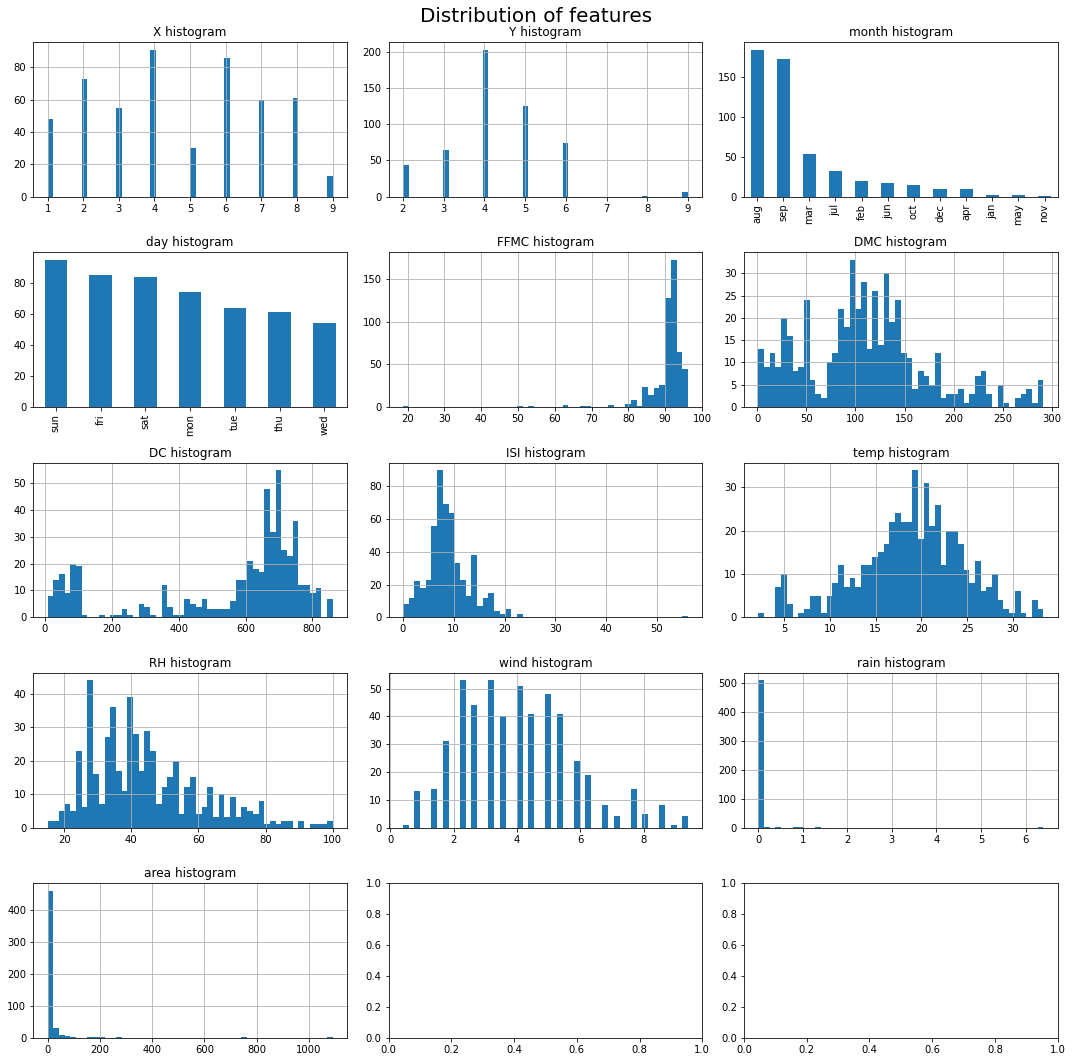

In [6]:
## Histograms of feature
def get_histogram(df,output):
    count=0
    for col in df.columns:
            count+=1
    if count%3==0:
        n_rows = count//3
    else:
        n_rows=(count//3)+1
    plt.subplots(n_rows,3,figsize=(15,15))
    i=0
    fig=[]
    for col in df.columns:
        if df[col].dtype != 'object':
            plt.subplot(n_rows,3,i+1)
            x=50
            df_new = df
            df_new[col].hist(bins=x)
            plt.title('{} histogram'.format(col))
            plt.suptitle('Distribution of features', fontsize=20)
            i+=1
        elif df[col].dtype == 'object':
#             col2=df[col].unique()
#             if(col=='month'):
#                 col2=sort_month(col2)
#             if(col=='day'):
#                 col2=sort_week(col2)
            plt.subplot(n_rows,3,i+1)
            df[col].value_counts().plot(kind='bar')
            plt.title('{} histogram'.format(col))
            i+=1
    plt.tight_layout()
    
display(get_histogram(df,'area'))

None

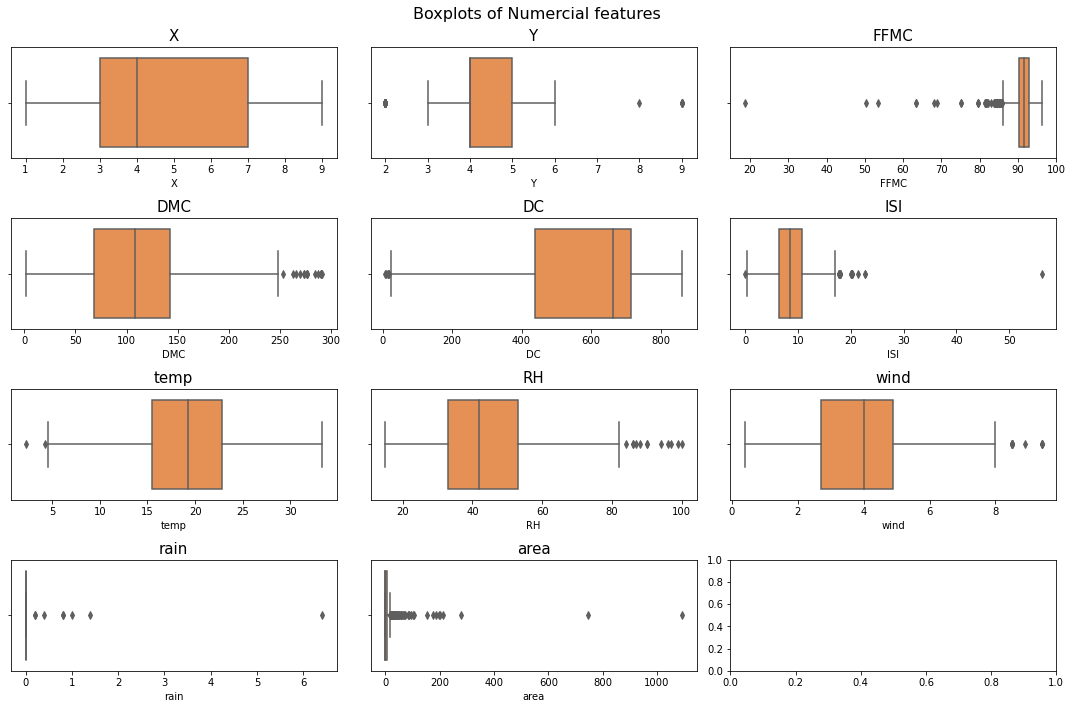

In [7]:

## Boxplots of numerical features
def boxplot_subplot(df):
    count=0
    for col in df.columns:
        if df[col].dtype!='object' and col!='Year':
            count+=1
        if count%3==0:
            n_rows = count//3
        else:
            n_rows=(count//3)+1
    plt.subplots(n_rows,3,figsize=(15,10))
    i=0
    fig=[]
    for col in df.columns:
        if df[col].dtype != 'object':
            fig.append(plt.subplot(n_rows,3,i+1))
            sns.boxplot(x=col,data=df,palette="Oranges_r",ax=fig[i]).set_title(col,fontsize=15)
            plt.suptitle('Boxplots of Numercial features', fontsize=16)
            plt.tight_layout()
            i+=1

display(boxplot_subplot(df))

<AxesSubplot:>

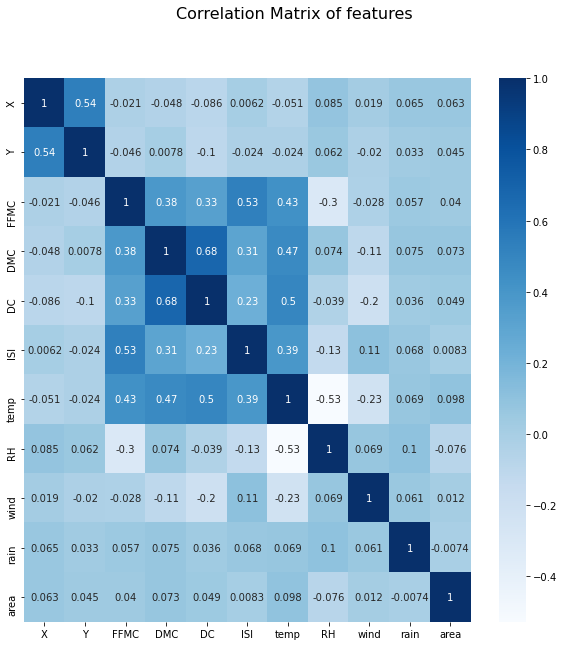

In [8]:
## Correlation matrix
plt.subplots(1,1,figsize=(10,10))
plt.subplot(1,1,1)
plt.suptitle('Correlation Matrix of features', fontsize=16)
corr = df.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

#### There is no big correlation among the independent variables, so we don't have to drop any variables as of now

In [9]:
def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

In [10]:
def pre_process(df, output):
    df = df.copy()
    
    # Ordinal encode month and day columns
    df = ordinal_encode(
        df,
        column='month',
        ordering=[
            'jan',
            'feb',
            'mar',
            'apr',
            'may',
            'jun',
            'jul',
            'aug',
            'sep',
            'oct',
            'nov',
            'dec'
        ]
    )
    df = ordinal_encode(
        df,
        column='day',
        ordering=[
            'sun',
            'mon',
            'tue',
            'wed',
            'thu',
            'fri',
            'sat'
        ]
    )
    
    # Split df into X and y
    y = df[output]
    
    X = df.drop('area', axis=1)
    
    return X, y 
    

In [11]:
X,y=pre_process(df, 'area')
y

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
       ...  
512     6.44
513    54.29
514    11.16
515     0.00
516     0.00
Name: area, Length: 517, dtype: float64

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale feature data (X)
scaler = StandardScaler()
scaler.fit(X_train)
    
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished

[2022-02-21 20:53:47] Features: 1/12 -- score: -4005.5083087693224[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished

[2022-02-21 20:53:47] Features: 2/12 -- score: -3986.536969296472[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished

[2022-02-21 20:53:47] Features: 3/12 -- score: -3978.626751312967[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

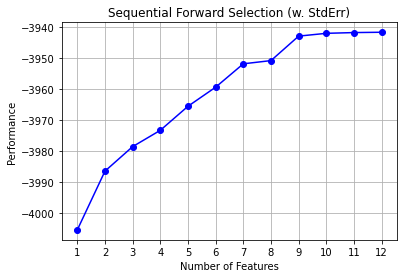

In [13]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

lreg = LinearRegression()



sfs1 = SFS(estimator=lreg, 
           k_features='best',
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=0)


sfs1 = sfs1.fit(X, y)
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [14]:
pd.DataFrame(sfs1.subsets_)

,1,2,3,4,5,6,7,8,9,10,11,12
feature_idx,"(8,)","(0, 8)","(0, 3, 8)","(0, 3, 7, 8)","(0, 3, 7, 8, 10)","(0, 3, 5, 7, 8, 10)","(0, 3, 5, 7, 8, 9, 10)","(0, 2, 3, 5, 7, 8, 9, 10)","(0, 2, 3, 5, 6, 7, 8, 9, 10)","(0, 2, 3, 5, 6, 7, 8, 9, 10, 11)","(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)"
cv_scores,[-4005.5083087693224],[-3986.536969296472],[-3978.626751312967],[-3973.3589238236555],[-3965.6009269616343],[-3959.4375100941347],[-3951.890972674071],[-3950.854184635242],[-3942.9542129406545],[-3942.050069160773],[-3941.8100815834205],[-3941.70174485466]
avg_score,-4005.51,-3986.54,-3978.63,-3973.36,-3965.6,-3959.44,-3951.89,-3950.85,-3942.95,-3942.05,-3941.81,-3941.7
feature_names,"(temp,)","(X, temp)","(X, day, temp)","(X, day, ISI, temp)","(X, day, ISI, temp, wind)","(X, day, DMC, ISI, temp, wind)","(X, day, DMC, ISI, temp, RH, wind)","(X, month, day, DMC, ISI, temp, RH, wind)","(X, month, day, DMC, DC, ISI, temp, RH, wind)","(X, month, day, DMC, DC, ISI, temp, RH, wind, ...","(X, month, day, FFMC, DMC, DC, ISI, temp, RH, ...","(X, Y, month, day, FFMC, DMC, DC, ISI, temp, R..."


In [15]:
sfs1.k_feature_names_

('X',
 'Y',
 'month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished

[2022-02-21 20:53:47] Features: 11/1 -- score: -3941.8100815834205[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished

[2022-02-21 20:53:47] Features: 10/1 -- score: -3942.050069160773[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished

[2022-02-21 20:53:47] Features: 9/1 -- score: -3942.9542129406545[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

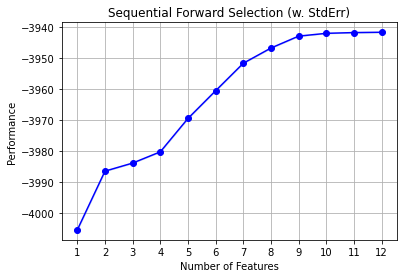

In [16]:
sfs2 = SFS(estimator=lreg, 
           k_features='best',
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=0)

sfs2 = sfs2.fit(X, y)
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [17]:
pd.DataFrame(sfs2.subsets_)

,12,11,10,9,8,7,6,5,4,3,2,1
feature_idx,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","(0, 2, 3, 5, 6, 7, 8, 9, 10, 11)","(0, 2, 3, 5, 6, 7, 8, 9, 10)","(0, 2, 3, 5, 6, 7, 8, 9)","(0, 2, 3, 5, 6, 7, 8)","(0, 2, 3, 5, 6, 8)","(0, 2, 5, 6, 8)","(0, 2, 6, 8)","(0, 2, 8)","(0, 8)","(8,)"
cv_scores,[-3941.70174485466],[-3941.8100815834205],[-3942.050069160773],[-3942.9542129406545],[-3946.7943242355277],[-3951.7053148971663],[-3960.572711222112],[-3969.5215100354203],[-3980.301774598711],[-3983.9304097335826],[-3986.536969296472],[-4005.5083087693224]
avg_score,-3941.7,-3941.81,-3942.05,-3942.95,-3946.79,-3951.71,-3960.57,-3969.52,-3980.3,-3983.93,-3986.54,-4005.51
feature_names,"(X, Y, month, day, FFMC, DMC, DC, ISI, temp, R...","(X, month, day, FFMC, DMC, DC, ISI, temp, RH, ...","(X, month, day, DMC, DC, ISI, temp, RH, wind, ...","(X, month, day, DMC, DC, ISI, temp, RH, wind)","(X, month, day, DMC, DC, ISI, temp, RH)","(X, month, day, DMC, DC, ISI, temp)","(X, month, day, DMC, DC, temp)","(X, month, DMC, DC, temp)","(X, month, DC, temp)","(X, month, temp)","(X, temp)","(temp,)"


In [18]:
sfs2.k_feature_names_

('X',
 'Y',
 'month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


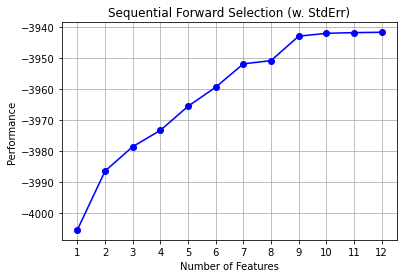

In [19]:
sffs = SFS(LinearRegression(),
         k_features='best',
         forward=True,
         floating=True,
         scoring='neg_mean_squared_error',
         cv=0)
sffs.fit(X, y)
fig = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()


In [20]:
sffs.k_feature_names_

('X',
 'Y',
 'month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain')

In [21]:
pd.DataFrame(sffs.subsets_)

,1,2,3,4,5,6,7,8,9,10,11,12
feature_idx,"(8,)","(0, 8)","(0, 3, 8)","(0, 3, 7, 8)","(0, 3, 7, 8, 10)","(0, 3, 5, 7, 8, 10)","(0, 3, 5, 7, 8, 9, 10)","(0, 2, 3, 5, 7, 8, 9, 10)","(0, 2, 3, 5, 6, 7, 8, 9, 10)","(0, 2, 3, 5, 6, 7, 8, 9, 10, 11)","(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)"
cv_scores,[-4005.5083087693224],[-3986.536969296472],[-3978.626751312967],[-3973.3589238236555],[-3965.6009269616343],[-3959.4375100941347],[-3951.890972674071],[-3950.854184635242],[-3942.9542129406545],[-3942.050069160773],[-3941.8100815834205],[-3941.70174485466]
avg_score,-4005.51,-3986.54,-3978.63,-3973.36,-3965.6,-3959.44,-3951.89,-3950.85,-3942.95,-3942.05,-3941.81,-3941.7
feature_names,"(temp,)","(X, temp)","(X, day, temp)","(X, day, ISI, temp)","(X, day, ISI, temp, wind)","(X, day, DMC, ISI, temp, wind)","(X, day, DMC, ISI, temp, RH, wind)","(X, month, day, DMC, ISI, temp, RH, wind)","(X, month, day, DMC, DC, ISI, temp, RH, wind)","(X, month, day, DMC, DC, ISI, temp, RH, wind, ...","(X, month, day, FFMC, DMC, DC, ISI, temp, RH, ...","(X, Y, month, day, FFMC, DMC, DC, ISI, temp, R..."


#### forward, backward and stepwise selection chooses all the variables with r2 and mean_suqared_error as scoring metric	


In [22]:
### Finding out the degree which works best for our data

# from sklearn.metrics import mean_squared_error

# rmses = []
# degrees = np.arange(2, 10)
# min_rmse, min_deg = 1e10, 0

# for deg in degrees:

#     # Train features
#     poly_reg = PolynomialFeatures(degree=deg, include_bias=False)
#     poly_features = poly_reg.fit_transform(df_scaled)
    
#     X_train, X_test, y_train, y_test= train_test_split(poly_features, df_output, 
#                                                    test_size=0.3,
#                                                    random_state=40)

#     poly_reg_model = LinearRegression()
#     poly_reg_model.fit(X_train, y_train)
    
#     poly_reg_y_predicted = poly_reg_model.predict(X_test)
    
#     poly_mse = mean_squared_error(y_test, poly_reg_y_predicted)
#     poly_rmse = np.sqrt(poly_mse)
#     rmses.append(poly_rmse)


In [23]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(degrees, rmses)
# ax.set_yscale('log')
# ax.set_xlabel('Degree')
# ax.set_ylabel('RMSE')

#### We will select degree 2 for polynomial regression as that works best for us data. Also it was asked in project description to use quadratic regression


In [26]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

# Adjusted R2 = 1 – [(1-R2)*(n-1)/(n-k-1)]
n=df.shape[0]
k=X_train.shape[1]-1

# Linear Regression
print("************** R^2 of Models **************\n")
lreg = LinearRegression()
lreg.fit(X_train,y_train)
predict_y = lreg.predict(X_test)
# print(r2_score(y_test,predict_y))
r2=r2_score(y_test,predict_y)
print("Linear Regression: R^2 score is", r2)
print("Linear Regression: Adjusted R^2 score is", 1-((1-r2)*(n-1)/(n-k-1)))
print("\n")


#################### LassoCV ########################
# Lasso with 5 fold cross-validation
model_l_cv = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model_l_cv.fit(X_train,y_train)
lasso_best = Lasso(alpha=model_l_cv.alpha_)
lasso_best.fit(X_train, y_train)
prediction_lasso=lasso_best.predict(X_test)
r2=r2_score(y_test,prediction_lasso)
# lasso = Lasso(alpha=0.5)
# lasso.fit(X_train,y_train)
# prediction_lasso = lasso.predict(X_test)
# r2=r2_score(y_test,prediction_lasso)
print("Best Alpha",model_l_cv.alpha_)
print("Lasso Regression: R^2 score is", r2)
print("Lasso Regression: Adjusted R^2 score is", 1 - ((1-r2)*(n-1)/(n-k-1)))
print("\n")


##################### RidgeCV #####################
#define model
model_cv = RidgeCV(alphas=np.arange(.1, 1,0.01), cv=5, scoring='neg_mean_absolute_error')

#fit model
model_cv.fit(X_train,y_train)

#display lambda that produced the lowest test MSE
print("Best Alpha", model_cv.alpha_)

prediction_ridge=model_cv.predict(X_test)

r2=r2_score(y_test, prediction_ridge)
# ridge = Ridge(alpha=.5)
# ridge.fit(X_train,y_train)
# prediction_ridge = ridge.predict(X_test)
# r2=r2_score(y_test,prediction_ridge)
print("Ridge Regression: R^2 score is", r2)
print("Ridge Regression: Adjusted R^2 score is", 1 - ((1-r2)*(n-1)/(n-k-1)))
print("\n")

poly_reg = PolynomialFeatures(degree=2)
poly_features = poly_reg.fit_transform(X_train)

poly_reg.fit(poly_features, y_train)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_train)
poly_reg_y_predicted = poly_reg_model.predict(poly_reg.fit_transform(X_test))
r2=r2_score(y_test,poly_reg_y_predicted)
print("Quadratic Regression: R^2 score is", r2)
print("Quadratic Regression: Adjusted R^2 score is", 1 - ((1-r2)*(n-1)/(n-k-1)))
print("\n")


print()
est_gp = SymbolicRegressor()
est_gp.fit(X_train,y_train)
y_gp = est_gp.predict(X_test)
predict_y_gp = est_gp.predict(X_test)
r2=r2_score(y_test,predict_y_gp)
print("Symbolic Regression: R^2 score is", r2)
print("Symbolic Regression: Adjusted R^2 score is", 1 - ((1-r2)*(n-1)/(n-k-1)))
print("\n")

************** R^2 of Models **************

Linear Regression: R^2 score is 0.021557347582511044
Linear Regression: Adjusted R^2 score is 0.00024473535163505034


Best Alpha 4.863009016651023
Lasso Regression: R^2 score is -6.493504504101466e-06
Lasso Regression: Adjusted R^2 score is -0.021788813164998366


Best Alpha 0.9899999999999995
Ridge Regression: R^2 score is 0.021558995633138567
Ridge Regression: Adjusted R^2 score is 0.0002464193003950399


Quadratic Regression: R^2 score is -9.640437028798407e+29
Quadratic Regression: Adjusted R^2 score is -9.850426746257383e+29



Symbolic Regression: R^2 score is -0.031840086261040845
Symbolic Regression: Adjusted R^2 score is -0.054315810912271445




In [27]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=2, random_state=10, shuffle=True)
# create model
lreg = LinearRegression()
lasso = Lasso(alpha=4.863009016651023)
ridge = Ridge(alpha=0.9899999999999995)
est_gp = SymbolicRegressor()
poly=LinearRegression()

models={lreg:"Linear Regression", lasso:"Lasso Regression", ridge:"Ridge Regression", poly:"Quadratic Regression",est_gp:"Symbolic Regression"}

print("************** R^2-cross-validated of Models **************\n")
for key in models:
    if key=='poly':
        poly_features = PolynomialFeatures(degree=2)
        X_poly = poly_features.fit_transform(X)
        poly_cv=cross_val_score(poly, X_poly, y, scoring='r2',cv=5)
        print(models[key]+' R^2 score is: %.3f (%.3f)' % (np.mean(poly_cv), np.std(scores))+"\n")
    else:
        # evaluate model
        scores = cross_val_score(key, X, y, scoring='r2', cv=cv, n_jobs=-1)
        # report performance
        print(models[key]+' R^2 score is: %.3f (%.3f)' % (np.mean(scores), np.std(scores))+"\n")
    

    

************** R^2-cross-validated of Models **************

Linear Regression R^2 score is: 0.001 (0.009)

Lasso Regression R^2 score is: 0.006 (0.002)

Ridge Regression R^2 score is: 0.003 (0.006)

Quadratic Regression R^2 score is: 0.001 (0.009)

Symbolic Regression R^2 score is: -0.042 (0.016)

